# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL as pl
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, AvgPool2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import os

import warnings
warnings.filterwarnings('ignore')

2024-05-09 09:21:38.998358: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 09:21:38.998471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 09:21:39.163303: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Used GPU

In [2]:
!nvidia-smi

Thu May  9 09:21:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Visualizing the Images

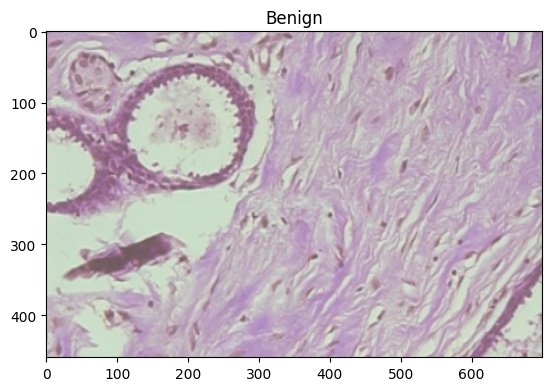

In [3]:
img = cv2.imread('/kaggle/input/breast-cancer-dataset/BreaKHis_Total_dataset/benign/SOB_B_A-14-22549AB-100-002.png')
plt.title('Benign')
plt.imshow(img)

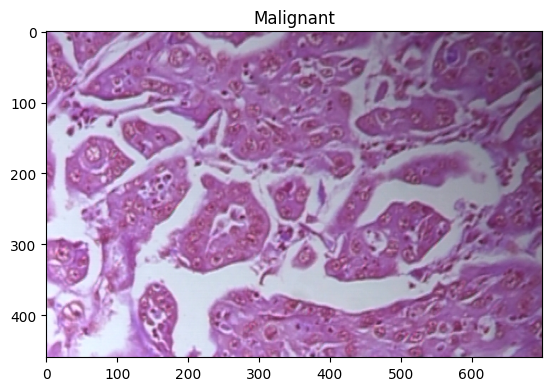

In [4]:
img = cv2.imread('/kaggle/input/breast-cancer-dataset/BreaKHis_Total_dataset/malignant/SOB_M_DC-14-10926-100-005.png')
plt.title('Malignant')
plt.imshow(img)

In [5]:
img.shape

(460, 700, 3)

# Train, Validation & Test Splitting the Data

In [6]:
dir = '/kaggle/input/breast-cancer-dataset/BreaKHis_Total_dataset'
img_width = 400
img_height = 400

In [7]:
#from tensorflow.keras.preprocessing import image_dataset_from_directory

train_data = image_dataset_from_directory(dir,label_mode = "categorical", image_size = (img_height, img_width),batch_size = 16, shuffle = True,seed = 5, validation_split = 0.3, subset = "training")
test_data = image_dataset_from_directory(dir,label_mode = "categorical", image_size = (img_height, img_width),batch_size = 16, shuffle = True,seed = 5, validation_split = 0.2, subset = "validation")
val_data = image_dataset_from_directory(dir,label_mode = "categorical", image_size = (img_height, img_width),batch_size = 16, shuffle = True,seed = 5, validation_split = 0.1, subset = "validation")

Found 7783 files belonging to 2 classes.
Using 5449 files for training.
Found 7783 files belonging to 2 classes.
Using 1556 files for validation.
Found 7783 files belonging to 2 classes.
Using 778 files for validation.


# Building the CNN Model

In [8]:
model = Sequential()

In [9]:
model.add(Conv2D(128, (3, 3), padding = 'same', input_shape = (400, 400, 3), activation = 'relu'))
model.add(AvgPool2D(2,2))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dropout(0.2, seed = 12))
model.add(Dense(3000, activation = 'relu'))
model.add(Dense(1500, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))

In [10]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 400, 400, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 200, 200, 128)  │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 200, 200, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 200, 200, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3000)           │   120,003,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1500)           │     4,501,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         3,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,212,142 (477.65 MB)

 Trainable params: 125,212,142 (477.65 MB)

 Non-trainable params: 0 (0.00 B)

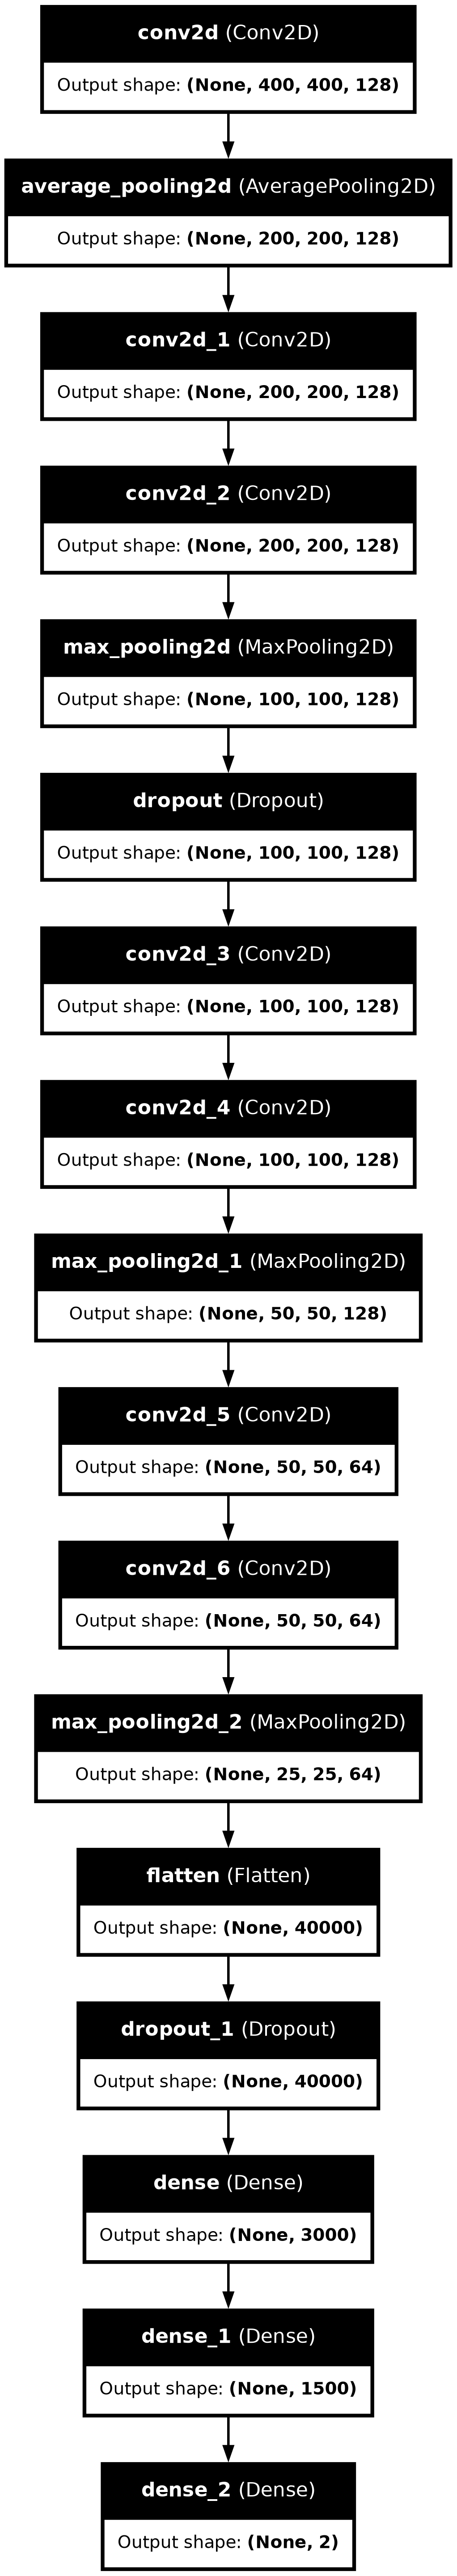

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Training the Model

## Employing the Early Stop

In [13]:
# Create a callback that will stop the training when the
# validation accuracy has not improved for 5 epochs
early_stopping = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 5, verbose = 1)

## Saving the Best Model as Checkpoint

In [14]:
out_dir = '/kaggle/working/best.keras'

checkpoint = ModelCheckpoint(filepath = out_dir, monitor = 'val_accuracy', mode = 'max', save_best_only = True, verbose =1)

## Training

In [15]:
history = model.fit(train_data, validation_data = val_data, epochs = 200, callbacks = [early_stopping, checkpoint])

Epoch 1/200


I0000 00:00:1715246571.272223      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715246571.291868      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


340/341 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6474 - loss: 78.1381

W0000 00:00:1715246690.776191      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.6475 - loss: 77.9533

W0000 00:00:1715246692.712218      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.75193, saving model to /kaggle/working/best.keras


W0000 00:00:1715246707.546204      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


341/341 ━━━━━━━━━━━━━━━━━━━━ 187s 416ms/step - accuracy: 0.6477 - loss: 77.7697 - val_accuracy: 0.7519 - val_loss: 0.5795
Epoch 2/200
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7502 - loss: 0.5320
Epoch 2: val_accuracy improved from 0.75193 to 0.76607, saving model to /kaggle/working/best.keras
341/341 ━━━━━━━━━━━━━━━━━━━━ 109s 317ms/step - accuracy: 0.7502 - loss: 0.5320 - val_accuracy: 0.7661 - val_loss: 0.5380
Epoch 3/200
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7757 - loss: 0.5079
Epoch 3: val_accuracy improved from 0.76607 to 0.77506, saving model to /kaggle/working/best.keras
341/341 ━━━━━━━━━━━━━━━━━━━━ 109s 317ms/step - accuracy: 0.7758 - loss: 0.5079 - val_accuracy: 0.7751 - val_loss: 0.5163
Epoch 4/200
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8031 - loss: 0.4653
Epoch 4: val_accuracy improved from 0.77506 to 0.78535, saving model to /kaggle/working/best.keras
341/341 ━━━━━━━━━━━━━━━━━━━━ 109s 317ms/step - accuracy: 0.8031 - loss: 

# Loading the Best Model for Evaluation

In [16]:
best_model = load_model(out_dir)

In [17]:
loss, acc = best_model.evaluate(test_data)
print(f'\nAccuracy = {acc}\nLoss = {loss}')

 1/98 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - accuracy: 0.8125 - loss: 0.5488

W0000 00:00:1715247572.070796      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.8324 - loss: 0.5246

Accuracy = 0.811053991317749
Loss = 0.5317137837409973


W0000 00:00:1715247586.990230      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Plotting the Accuracy vs. Epochs Graph

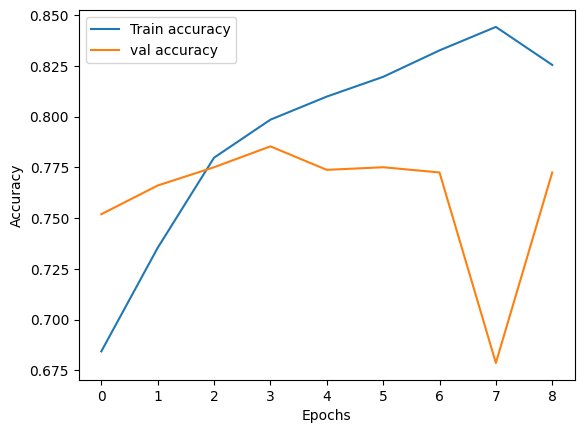

In [18]:
plt.plot(history.history['accuracy'], label = 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')

# Plotting the Loss vs. Epochs Graph

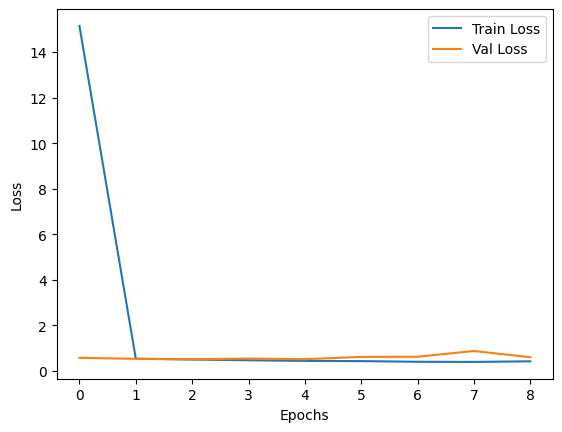

In [19]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')

<br>
<p style="text-align:center; font-weight:800; font-size:18px"><em>Thank you For viewing this Notebook 😃, do upvote 🔼 if you like it and please feel free to provide any feedback.</em>
<p style="text-align:center"><img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExbWRqbzB6dTFuYm5rY29nMXF5b3kyajZhc2NzN2dlY3c5bmcycDIwaCZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/fxI1G5PNC5esyNlIUs/giphy.gif" width="480" height="200"></p>
